*Can we predict wine quality from its chemical properties alone?*

In my day job, I develop AI tools to boost productivity and efficiency across my organization. While this occasionally involves designing machine learning architectures, much of it revolves around orchestrating LLM APIs like OpenAI’s or Anthropic’s.

Curious to deepen my understanding of how these models work under the hood, I’ve decided to start from the ground up—by implementing foundational learning algorithms from scratch.

Initially, I considered using the MNIST dataset to predict handwritten digits. However, I wanted something a bit more engaging and relatable. That’s when I came across this Wine Quality Dataset [@wine_quality_186] from the UCI Machine Learning Repository.

This dataset contains several chemical properties of wine samples and their corresponding quality ratings (on a scale from 1 to 10). It immediately struck me as a more interesting and real-world challenge: predicting something as subjective as wine quality from raw chemical data.

## What We'll Explore

In this post, we’ll walk through:

- **The Dataset**: Exploring 11 chemical features from 6,497 wine samples to uncover patterns beneath the surface.
- **Machine Learning from Scratch**: Implementing and comparing three models without using high-level ML libraries:
  - Simple Linear Regression (as a baseline)
  - Logistic Regression (to treat the problem as classification)
  - A Neural Network (to introduce deep learning fundamentals)
- **Practical Insights**: Highlighting which chemical properties actually influence perceived wine quality.


Let’s dive in and see what the data can reveal.

In [1]:
# Import required libraries
import numpy as np                    
import pandas as pd
from time import time
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display
from ucimlrepo import fetch_ucirepo   # UCI Machine Learning Repository access


# Set random seed for reproducibility across runs
np.random.seed(42)

# Configure matplotlib for clean plots
plt.style.use('default')
plt.rcParams['figure.facecolor'] = 'white'

# Fetch the wine quality dataset from UCI ML Repository
print("Loading Wine Quality dataset...")
wine_quality = fetch_ucirepo(id=186)  # ID 186 = Wine Quality dataset
print("Dataset loaded successfully!") 

Loading Wine Quality dataset...
Dataset loaded successfully!


## Data Exploration

Let's start by examining the structure and characteristics of our dataset. We'll look at the features, their distributions, and understand what each variable represents in the context of wine quality assessment.

In [2]:
# Extract features and target variable
X = wine_quality.data.features 
y = wine_quality.data.targets

# Display basic dataset information
print("Dataset Information:")
print(f"Number of samples: {len(X)}")
print(f"Number of features: {len(X.columns)}")

print("\n\n" + "="*50)
print("Sample Data Preview:")
print("="*50)

print("\nFeature Data (first 5 samples):")
display(X.head())

print("\nTarget Data (first 5 samples):")
display(y.head())

print(f"\nTarget distribution (quality ratings):")
display(y['quality'].value_counts().sort_index())

Dataset Information:
Number of samples: 6497
Number of features: 11


Sample Data Preview:

Feature Data (first 5 samples):


,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4



Target Data (first 5 samples):


,quality
0,5
1,5
2,5
3,6
4,5



Target distribution (quality ratings):


quality
3      30
4     216
5    2138
6    2836
7    1079
8     193
9       5
Name: count, dtype: int64

### Feature Descriptions

Understanding the physicochemical properties that influence wine quality is essential to our analysis. Below is a breakdown of each feature in the dataset:

#### Chemical Properties
- **Fixed Acidity**: Tartaric acid content (g/dm³)  
  → The primary acid in grapes; contributes to a wine’s tartness and balances sweetness.

- **Volatile Acidity**: Acetic acid content (g/dm³)  
  → High levels can lead to a vinegar-like taste, often considered a flaw.

- **Citric Acid**: Citric acid content (g/dm³)  
  → Occasionally added to enhance freshness, flavor, and balance.

- **pH**: Acidity level (typically between 3 and 4)  
  → A lower pH indicates higher acidity, influencing taste and microbial stability.

#### Preservation & Additives
- **Free Sulfur Dioxide**: Unbound SO₂ (mg/dm³)  
  → Acts as an antioxidant and antimicrobial agent; crucial for wine preservation.

- **Total Sulfur Dioxide**: Combined free and bound SO₂ (mg/dm³)  
  → Total measure of sulfur dioxide used in production and preservation.

- **Sulphates**: Sulfate content (g/dm³)  
  → A natural preservative that can enhance shelf life and protect against spoilage.

- **Chlorides**: Chloride content (g/dm³)  
  → Influenced by mineral content and location; excessive levels may lead to off-flavors.

#### Structural Components
- **Density**: Wine density (g/cm³)  
  → Correlated with residual sugar and alcohol content; can indicate fermentation progress.

- **Residual Sugar**: Unfermented grape sugars (g/dm³)  
  → Contributes to the wine’s sweetness and mouthfeel.

- **Alcohol**: Alcohol percentage by volume  
  → A primary driver of wine character and body; often correlates with quality scores.

---

Now that we understand what each feature represents, let’s visualize their distributions to get a better sense of how they vary across our dataset.

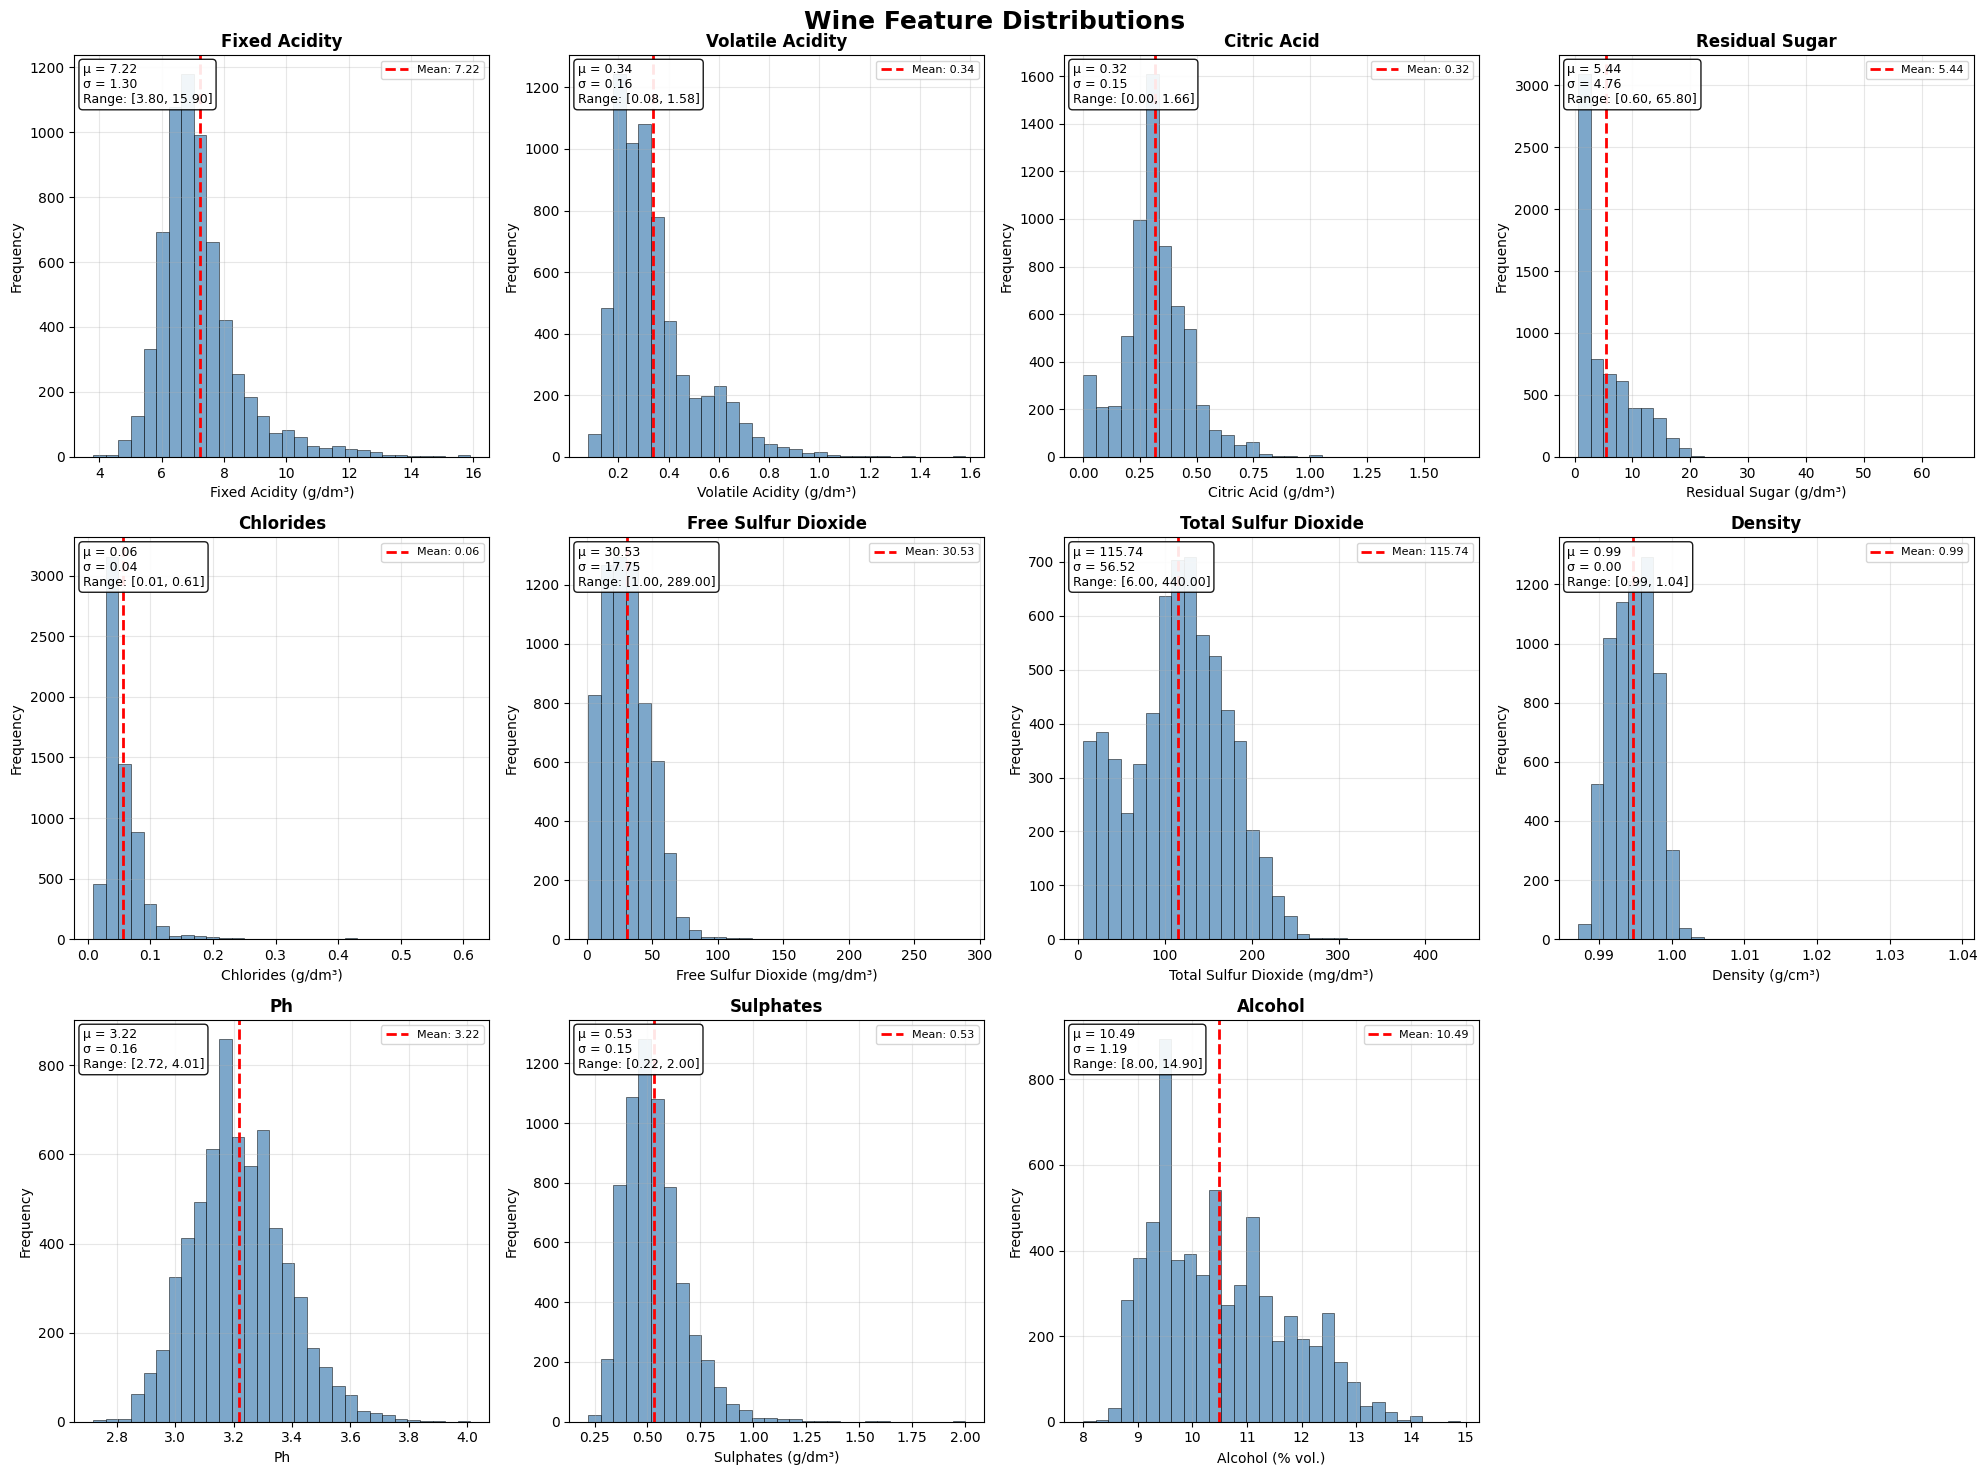


Feature Summary Statistics:


,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol
count,6497.00,6497.00,6497.00,6497.00,6497.00,6497.00,6497.00,6497.00,6497.00,6497.00,6497.00
mean,7.22,0.34,0.32,5.44,0.06,30.53,115.74,0.99,3.22,0.53,10.49
std,1.30,0.16,0.15,4.76,0.04,17.75,56.52,0.00,0.16,0.15,1.19
min,3.80,0.08,0.00,0.60,0.01,1.00,6.00,0.99,2.72,0.22,8.00
25%,6.40,0.23,0.25,1.80,0.04,17.00,77.00,0.99,3.11,0.43,9.50
50%,7.00,0.29,0.31,3.00,0.05,29.00,118.00,0.99,3.21,0.51,10.30
75%,7.70,0.40,0.39,8.10,0.06,41.00,156.00,1.00,3.32,0.60,11.30
max,15.90,1.58,1.66,65.80,0.61,289.00,440.00,1.04,4.01,2.00,14.90


In [3]:
# | code-fold: true
# Create comprehensive feature distribution plots
fig, axes = plt.subplots(3, 4, figsize=(20, 15))
fig.suptitle('Wine Feature Distributions', fontsize=18, fontweight='bold', y=0.98)

# Define units for each feature
feature_units = {
    'fixed_acidity': r'(g/dm³)',
    'volatile_acidity': r'(g/dm³)',
    'citric_acid': r'(g/dm³)',
    'residual_sugar': r'(g/dm³)',
    'chlorides': r'(g/dm³)',
    'free_sulfur_dioxide': r'(mg/dm³)',
    'total_sulfur_dioxide': r'(mg/dm³)',
    'density': r'(g/cm³)',
    'pH': '',
    'sulphates': r'(g/dm³)',
    'alcohol': r'(% vol.)'
}

# Flatten axes for easier indexing
axes = axes.flatten()

# Create histograms for each feature
for i, feature in enumerate(X.columns):
    ax = axes[i]
    
    # Create histogram with improved styling
    n, bins, patches = ax.hist(X[feature], bins=30, alpha=0.7, 
                              color='steelblue', edgecolor='black', linewidth=0.5)
    
    # Calculate statistics
    mean_val = X[feature].mean()
    std_val = X[feature].std()
    
    # Add vertical lines for median
    ax.axvline(mean_val, color='red', linestyle='--', linewidth=2, 
               label=f'Mean: {mean_val:.2f}')
    
    # Add statistical information as text
    stats_text = f'μ = {mean_val:.2f}\nσ = {std_val:.2f}\nRange: [{X[feature].min():.2f}, {X[feature].max():.2f}]'
    ax.text(0.02, 0.98, stats_text, transform=ax.transAxes, fontsize=9,
            verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.9))
    
    # Format axis labels
    unit = feature_units.get(feature, '')
    feature_name = feature.replace("_", " ").title()
    xlabel = f'{feature_name} {unit}' if unit else feature_name

    # Customize the plot
    ax.set_title(feature_name, fontweight='bold', fontsize=12)
    ax.set_xlabel(xlabel, fontsize=10)
    ax.set_ylabel('Frequency', fontsize=10)
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=8)

# Hide the unused subplot (12th position)
axes[11].set_visible(False)

# Adjust layout and display
plt.tight_layout()
plt.subplots_adjust(top=0.95)
plt.show()

# Print summary statistics
print("\nFeature Summary Statistics:")
print("=" * 60)
display(X.describe().round(2))

Aside: *I can't believe I only just learned about the pandas .describe() method. Incredibly helpful.*

## Data Preprocessing

Before we can train any models, we need to prepare the dataset. This includes checking for missing values, standardizing our features, and splitting the data into training and testing sets.

### The Data Quality Check

First things first — let’s confirm that our dataset is complete. Missing values can disrupt training and lead to misleading results, so it’s important to address them up front.


In [4]:
# | code-fold: true
# Check for missing values in features
missing_features = X.isnull().sum()
print("Missing values in features:")
print(missing_features)
print(f"\nTotal missing values: {missing_features.sum()}")

# Check for missing values in target
missing_target = y.isnull().sum()
print(f"\nMissing values in target: {missing_target.values[0]}")

# Summary
if missing_features.sum() == 0 and missing_target.sum() == 0:
    print("\n✓ Excellent! No missing values found in the dataset.")
else:
    print(f"\n⚠ Warning: Found {missing_features.sum() + missing_target.sum()} missing values that need to be addressed.")

Missing values in features:
fixed_acidity           0
volatile_acidity        0
citric_acid             0
residual_sugar          0
chlorides               0
free_sulfur_dioxide     0
total_sulfur_dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
dtype: int64

Total missing values: 0

Missing values in target: 0

✓ Excellent! No missing values found in the dataset.


### Data Standardization

Excellent, our dataset is complete! The next step is to standardize our features so they’re on a common scale.

**Why do we do this?**  
Consider the difference between alcohol percentage (typically 8–15%) and total sulfur dioxide (which can exceed 300 mg/dm³). Without standardization, features with larger numeric ranges can disproportionately influence our models — even if they’re not more important.

**The Solution**  
We’ll use Z-score normalization, which transforms each feature to have a mean of 0 and a standard deviation of 1:

$$
z = \frac{x - \mu}{\sigma}
$$

This ensures that all features contribute equally when we train our models.


**Train-Test Split**: We'll also split our data into training (80%) and testing (20%) sets. This allows us to evaluate how well our models perform on unseen data.

In [5]:
# Define train-test split ratio
TRAIN_SIZE = 0.8
TEST_SIZE = 1 - TRAIN_SIZE

print(f"Data split: {TRAIN_SIZE*100:.0f}% training, {TEST_SIZE*100:.0f}% testing")

# Calculate standardization parameters from the full dataset
X_means = X.mean()
X_stds = X.std()
y_means = y.mean()
y_stds = y.std()

# Apply z-score standardization: (x - mean) / std
# This transforms features to have mean=0 and std=1
X_norm = (X - X_means) / X_stds
y_norm = (y - y_means) / y_stds

print(f"\nStandardization completed:")
print(f"Features - Mean: {X_norm.mean().mean():.2e}, Std: {X_norm.std().mean():.2f}")
print(f"Target - Mean: {y_norm.mean().values[0]:.2e}, Std: {y_norm.std().values[0]:.2f}")

# Split data into training and testing sets
split_idx = int(TRAIN_SIZE * len(X_norm))

X_train = X_norm.iloc[:split_idx]
X_test = X_norm.iloc[split_idx:]
y_train = y_norm.iloc[:split_idx]
y_test = y_norm.iloc[split_idx:]

# Ensure no samples are lost in the split
data_integrity = (len(X_norm) == len(X_train) + len(X_test)) and (len(y_norm) == len(y_train) + len(y_test))
print(f"\nNo data lost: {data_integrity}")

# Display dataset information in a clean format
print("\nDataset Shapes:")
print(f"{'Set':<10} {'Features':<15} {'Target':<15}")
print("-" * 40)
print(f"{'Training':<10} {str(X_train.shape):<15} {str(y_train.shape):<15}")
print(f"{'Testing':<10} {str(X_test.shape):<15} {str(y_test.shape):<15}")
print(f"{'Total':<10} {str(X_norm.shape):<15} {str(y_norm.shape):<15}")

Data split: 80% training, 20% testing

Standardization completed:
Features - Mean: -9.23e-17, Std: 1.00
Target - Mean: -2.89e-16, Std: 1.00

No data lost: True

Dataset Shapes:
Set        Features        Target         
----------------------------------------
Training   (5197, 11)      (5197, 1)      
Testing    (1300, 11)      (1300, 1)      
Total      (6497, 11)      (6497, 1)      


## Machine Learning Models

Now for the fun part — building models to predict wine quality! I’ll implement three approaches, each increasing in complexity. By building them from scratch, we’ll gain an intuitive understanding of what’s happening under the hood.

### 1. Simple Linear Regression (Single Feature)

Let’s begin with the most basic model: predicting wine quality using just one feature, pH. This serves as a baseline and helps us explore whether a simple linear relationship exists between acidity and quality.

**Why pH?**  
From our earlier exploration, pH was one of the most normally distributed features and represents a core characteristic of wine. Starting with a single feature also simplifies the math and makes model behavior easier to interpret.


#### The Mathematical Model

Our linear regression model is defined as:

$$
\hat{y} = \theta_0 + \theta_1 x
$$

Where $\hat{y}$ is the predicted wine quality (standardized), $x$ is the feature value (standardized pH value), and $\theta_i$ is the model parameter.


#### Cost Function

We’ll use Mean Squared Error (MSE) to measure model performance:

$$
J(\boldsymbol{\theta}) = \frac{1}{2m} \sum_{i=1}^{m} (\hat{y}^{(i)} - y^{(i)})^2
$$

Where $m$ is the number of training samples, $y^{(i)}$ is the true value, and $\hat{y}^{(i)}$ is the predicted value.


#### Parameter Optimization

To minimize the cost, we’ll apply gradient descent. The gradients of the cost function with respect to each parameter are:

$$
\frac{\partial J}{\partial \theta_0} = \frac{1}{m} \sum_{i=1}^{m} (\hat{y}^{(i)} - y^{(i)})
$$

$$
\frac{\partial J}{\partial \theta_1} = \frac{1}{m} \sum_{i=1}^{m} (\hat{y}^{(i)} - y^{(i)}) x^{(i)}
$$

We update the parameters using the learning rate $\alpha$:

$$
\theta_j := \theta_j - \alpha \frac{\partial J}{\partial \theta_j}
$$

This iterative process continues until convergence — or until we’ve reached a maximum number of iterations.

---

In [6]:
class LinearRegression:
    """
    Simple Linear Regression implementation using gradient descent
    """
    
    def __init__(self, learning_rate=0.01, max_iterations=1000, tolerance=1e-10):
        """
        Initialize the linear regression model
        
        Parameters:
        - learning_rate: Step size for gradient descent
        - max_iterations: Maximum number of training iterations
        - tolerance: Convergence threshold (stop when cost change < tolerance)
        """
        self.learning_rate = learning_rate
        self.max_iterations = max_iterations
        self.tolerance = tolerance
        self.theta_0 = 0
        self.theta_1 = 0
        self.cost_history = []
        
    def cost_function(self, X, y):
        """
        Calculate Mean Squared Error cost
        """
        m = len(X)
        predictions = self.theta_0 + self.theta_1 * X
        return (1/(2*m)) * np.sum((predictions - y)**2)
    
    def fit(self, X, y):
        """Train the model using gradient descent"""
        m = len(X)
        
        # Record initial cost
        initial_cost = self.cost_function(X, y)
        self.cost_history.append(initial_cost)
        
        print(f"Starting training with initial cost: {initial_cost:.6f}")
        
        for iteration in range(self.max_iterations):
            # Forward pass: calculate predictions and errors
            predictions = self.theta_0 + self.theta_1 * X
            errors = predictions - y
            
            # Calculate gradients (partial derivatives of cost function)
            theta_0_grad = (1/m) * np.sum(errors)
            theta_1_grad = (1/m) * np.sum(errors * X)
            
            # Update parameters using gradient descent
            self.theta_0 -= self.learning_rate * theta_0_grad
            self.theta_1 -= self.learning_rate * theta_1_grad
            
            # Calculate new cost to track progress
            current_cost = self.cost_function(X, y)
            self.cost_history.append(current_cost)
            
            # Print progress every 100 iterations
            if iteration % 100 == 0:
                print(f"Iteration {iteration:4d}: Cost = {current_cost:.6f}")
                
            # Check for convergence (stop if cost change is very small)
            if len(self.cost_history) > 1:
                cost_change = abs(self.cost_history[-2] - self.cost_history[-1])
                if cost_change < self.tolerance:
                    print(f"Converged at iteration {iteration} (cost change: {cost_change:.2e})")
                    break
                    
        final_cost = self.cost_history[-1]
        print(f"Training completed. Final cost: {final_cost:.6f}")
        return self
    
    def predict(self, X):
        """
        Make predictions using the trained model
        """
        return self.theta_0 + self.theta_1 * X

# Prepare data for simple linear regression
X_linear = X_train['pH'].to_numpy()
y_linear = y_train.to_numpy().flatten()

print("Simple Linear Regression Training")
print("=" * 40)
print(f"Feature: pH")
print(f"Training samples: {len(X_linear)}")
print(f"Learning rate: 0.01")
print()

# Train the model
model_linear = LinearRegression(learning_rate=0.1, max_iterations=1000)
model_linear.fit(X_linear, y_linear)

print(f"\nLearned parameters:")
print(f"θ_0 (intercept): {model_linear.theta_0:.6f}")
print(f"θ_1 (slope): {model_linear.theta_1:.6f}")

Simple Linear Regression Training
Feature: pH
Training samples: 5197
Learning rate: 0.01

Starting training with initial cost: 0.519063
Iteration    0: Cost = 0.518987
Converged at iteration 70 (cost change: 8.29e-11)
Training completed. Final cost: 0.518638

Learned parameters:
θ_0 (intercept): -0.019141
θ_1 (slope): 0.023184


#### Training Progress Visualization

Let's visualize how the cost function decreased during training to understand the convergence behavior.

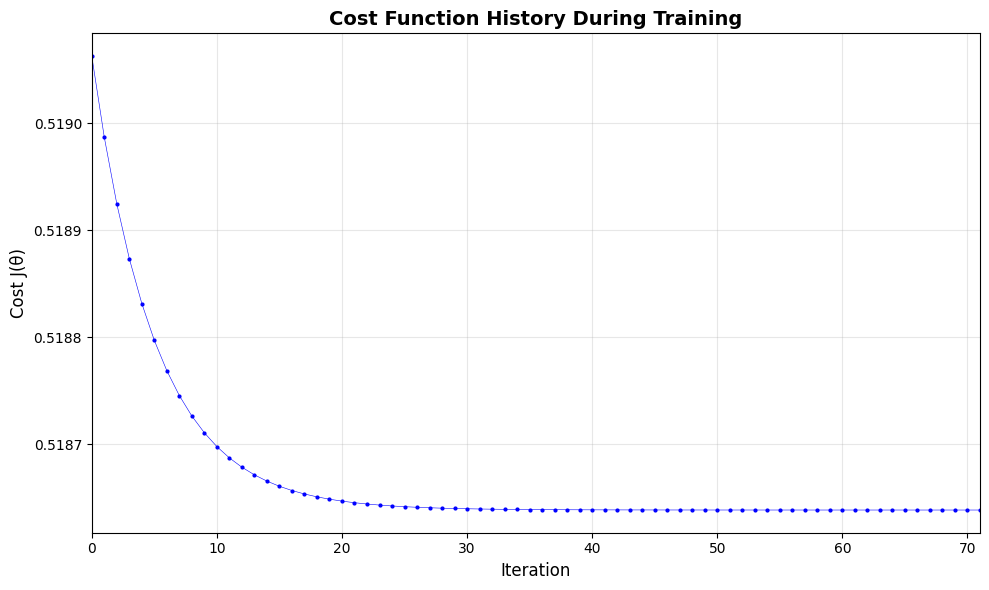

In [7]:
# | code-fold : true
# Plot the cost history
cost_array = model_linear.cost_history

plt.figure(figsize=(10, 6))
plt.plot(range(len(cost_array)), cost_array, 'b-', linewidth=0.4, marker='o', markersize=2)
plt.title('Cost Function History During Training', fontsize=14, fontweight='bold')
plt.xlabel('Iteration', fontsize=12)
plt.ylabel('Cost J(θ)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.xlim(0, len(cost_array)-1)

plt.tight_layout()
plt.show()

# Print some statistics about the cost reduction
initial_cost = cost_array[0]
final_cost = cost_array[-1]
cost_reduction = initial_cost - final_cost
percent_reduction = (cost_reduction / initial_cost) * 100


#### Model Evaluation and Visualization

Now let's evaluate our simple linear regression model using standard metrics and visualize the results. We'll calculate the $R^2$ score and create a comprehensive visualization of the model's performance.

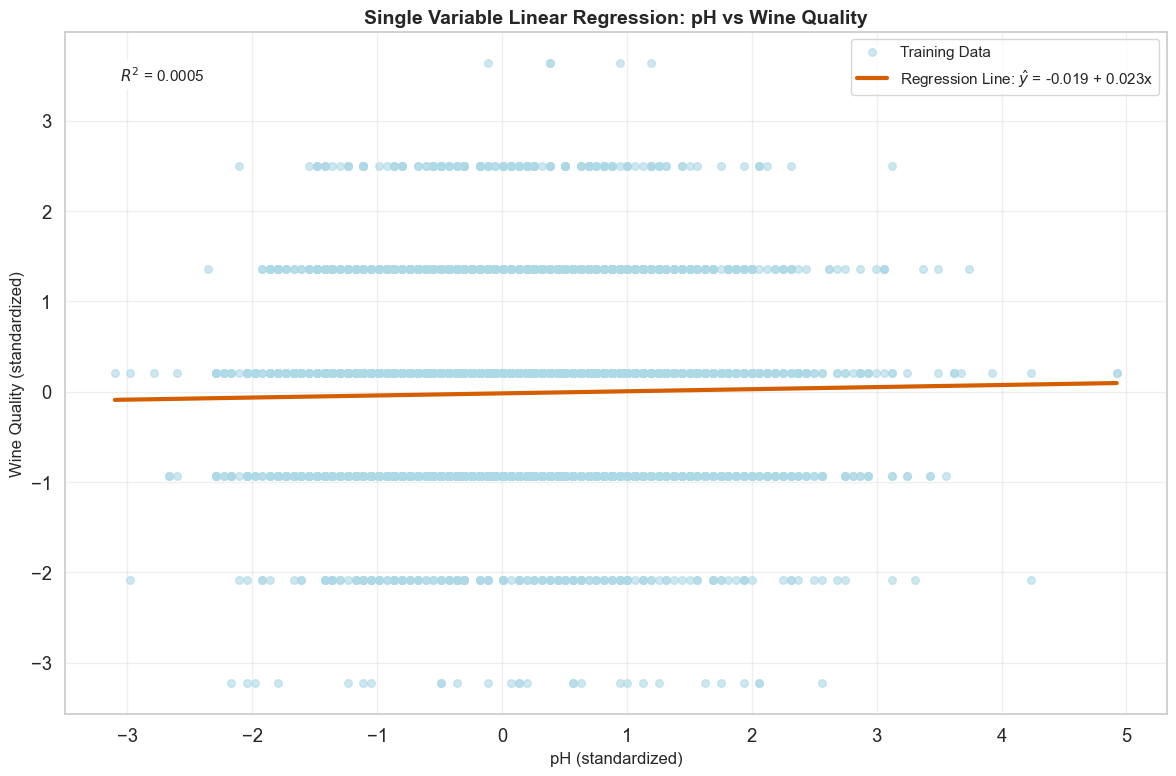

In [24]:
# | code-fold : true
# Plot the linear regression line with the data
plt.figure(figsize=(12, 8))

# Plot the training data points
plt.scatter(X_linear, y_linear, alpha=0.6, color='lightblue', s=30, label='Training Data')

# Create a range of x values for the regression line
x_range = np.linspace(X_linear.min(), X_linear.max(), 100)
y_pred = model_linear.theta_0 + model_linear.theta_1 * x_range

# Plot the regression line
plt.plot(x_range, y_pred, 'r-', linewidth=3, label=fr'Regression Line: $\hat{{y}}$ = {model_linear.theta_0:.3f} + {model_linear.theta_1:.3f}x')

# Customize the plot
plt.title('Single Variable Linear Regression: pH vs Wine Quality', fontsize=14, fontweight='bold')
plt.xlabel('pH (standardized)', fontsize=12)
plt.ylabel('Wine Quality (standardized)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=11)

# Add R^2 score
r_squared = 1 - (np.sum((y_linear - (model_linear.theta_0 + model_linear.theta_1 * X_linear))**2) / 
                 np.sum((y_linear - np.mean(y_linear))**2))

plt.text(0.05, 0.95, f'$R^2$ = {r_squared:.4f}', 
         transform=plt.gca().transAxes, fontsize=11, 
         bbox=dict(boxstyle='round', facecolor='white'),
         verticalalignment='top')

plt.tight_layout()
plt.show()



With an $R^2$ score of just 0.0005, our simple linear regression model is essentially useless for predicting wine quality. In other words, wine quality isn’t determined by pH alone. This intuitively makes sense.

**What Does This Tell Us?**
- The relationship between pH and wine quality is incredibly weak.
- Wine quality likely depends on the interaction of many chemical factors.
- We need a more sophisticated, multivariate approach.

This “failure” is actually valuable. It reinforces the complexity of the problem: wine quality isn’t something you can capture with a single variable. Let’s see how a more capable model performs.

---

### 2. Logistic Regression

Instead of predicting an exact score — which is subjective and often noisy — let’s simplify the problem:

> Is this wine high quality or not?

We'll define:

- High Quality: Wine quality $>= 7 \rightarrow$ label = 1  
- Low Quality: Wine quality $< 7 \rightarrow$ label = 0

This framing allows us to use logistic regression, a foundational classification algorithm.


#### The Mathematical Model

Logistic regression applies the sigmoid function to the linear combination of inputs, transforming predictions into probabilities between 0 and 1:

$$
\hat{y} = \sigma(X\boldsymbol{\theta}) = \frac{1}{1 + e^{-X\boldsymbol{\theta}}}
$$

Where $X$ is our feature matrix (all 11 chemical properties), $\boldsymbol{\theta}$ is the parameter vector we’re learning, and $\sigma$ is the sigmoid activation function.

#### Parameter Optimization

To train this model, we’ll use Binary Cross-Entropy Loss:

$$
J(\boldsymbol{\theta}) = -\frac{1}{m} \sum_{i=1}^{m} \left[ y^{(i)} \log(\hat{y}^{(i)}) + (1 - y^{(i)}) \log(1 - \hat{y}^{(i)}) \right]
$$

What’s continually impressed me while learning about various machine learning architectures, is how simple the gradients often turn out to be. In this case, the gradient of the loss function is:

$$
\nabla J(\boldsymbol{\theta}) = \frac{1}{m} X^T (\hat{y} - y)
$$

This is almost identical to the gradient for linear regression — the only difference is that $\hat{y}$ now comes from the sigmoid function.

---

In [9]:
class LogisticRegression:
    """
    Logistic Regression implementation using gradient descent
    """
    
    def __init__(self, learning_rate=0.01, max_iterations=1000, tolerance=1e-6):
        self.learning_rate = learning_rate
        self.max_iterations = max_iterations
        self.tolerance = tolerance
        self.theta = None
        self.cost_history = []
        
    def sigmoid(self, z):
        """Sigmoid activation function"""
        return 1 / (1 + np.exp(-z))
    
    def cost_function(self, X, y):
        """Calculate Binary Cross-Entropy cost"""
        m = len(X)
        z = X @ self.theta
        h = self.sigmoid(z)
        
        cost = -(1/m) * np.sum(y * np.log(h) + (1 - y) * np.log(1 - h))
        return cost
    
    def fit(self, X, y):
        """Train the model using gradient descent"""
        m, n = X.shape
        
        # Initialize parameters
        self.theta = np.random.normal(0, 0.01, (n, 1))
        
        # Record initial cost
        initial_cost = self.cost_function(X, y)
        self.cost_history.append(initial_cost)
        
        print(f"Starting logistic regression training...")
        print(f"Initial cost: {initial_cost:.6f}")
        print(f"Features: {n}, Samples: {m}")
        print()
        
        for iteration in range(self.max_iterations):
            # Forward pass
            z = X @ self.theta
            h = self.sigmoid(z)
            
            # Calculate gradient
            gradient = (1/m) * X.T @ (h - y)
            
            # Update parameters
            self.theta -= self.learning_rate * gradient
            
            # Calculate new cost
            current_cost = self.cost_function(X, y)
            self.cost_history.append(current_cost)
            
            # Print progress
            if iteration % 100 == 0:
                print(f"Iteration {iteration:4d}: Cost = {current_cost:.6f}")
                
            # Check for convergence
            if len(self.cost_history) > 1:
                cost_change = abs(self.cost_history[-2] - self.cost_history[-1])
                if cost_change < self.tolerance:
                    print(f"Converged at iteration {iteration} (cost change: {cost_change:.2e})")
                    break
                    
        final_cost = self.cost_history[-1]
        print(f"Training completed. Final cost: {final_cost:.6f}")
        return self
    
    def predict_proba(self, X):
        """Predict class probabilities"""
        z = X @ self.theta
        return self.sigmoid(z)
    
    def predict(self, X, threshold=0.5):
        """Make binary predictions"""
        probabilities = self.predict_proba(X)
        return (probabilities >= threshold).astype(int)

# Data preparation for logistic regression
print("Preparing data for logistic regression...")
print("=" * 45)

# Transform target to binary classification (quality >= 7 = 1, else 0)
quality_threshold = 7
y_binary = (y['quality'] >= quality_threshold).astype(int).values.reshape(-1, 1)

# Split binary target
y_train_binary = y_binary[:len(X_train)]
y_test_binary = y_binary[len(X_train):]

# Use standardized features
X_train_logistic = X_train.values
X_test_logistic = X_test.values

# Display class distribution
train_positive = np.sum(y_train_binary)
train_total = len(y_train_binary)
test_positive = np.sum(y_test_binary)
test_total = len(y_test_binary)

print(f"Quality threshold: {quality_threshold}")
print(f"Training set: {train_positive}/{train_total} ({train_positive/train_total*100:.1f}%) high quality")
print(f"Test set: {test_positive}/{test_total} ({test_positive/test_total*100:.1f}%) high quality")
print()

# Train logistic regression model
model_logistic = LogisticRegression(learning_rate=0.2, max_iterations=250)
model_logistic.fit(X_train_logistic, y_train_binary)
print("=" * 45)


Preparing data for logistic regression...
Quality threshold: 7
Training set: 1030/5197 (19.8%) high quality
Test set: 247/1300 (19.0%) high quality

Starting logistic regression training...
Initial cost: 0.695249
Features: 11, Samples: 5197

Iteration    0: Cost = 0.679790
Iteration  100: Cost = 0.588730
Iteration  200: Cost = 0.587354
Training completed. Final cost: 0.587092


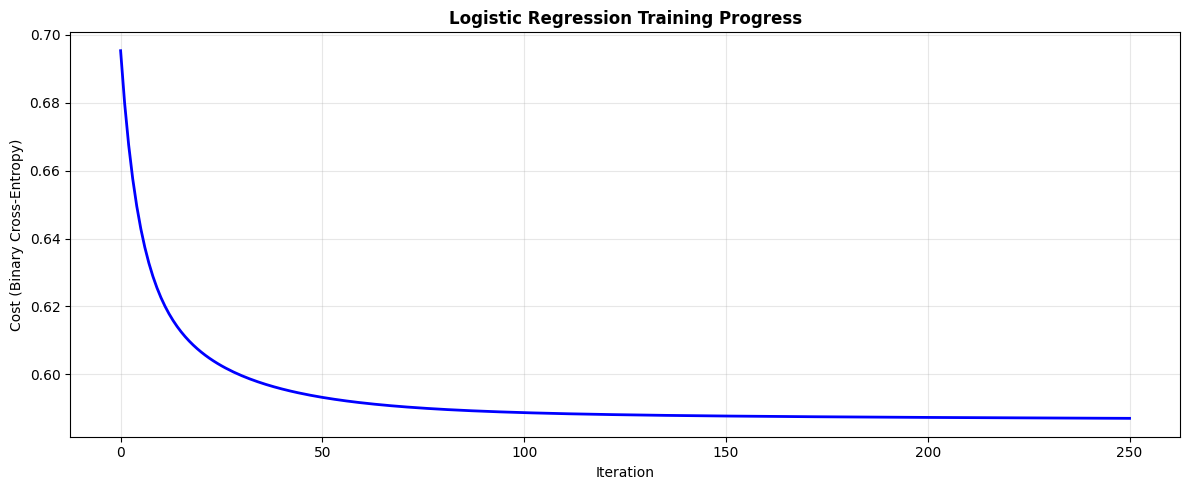

Training completed in 250 iterations
Final training cost: 0.587092


In [10]:
# | code-fold: true
# Visualize training progress
plt.figure(figsize=(12, 5))

# Plot cost history
plt.plot(range(len(model_logistic.cost_history)), model_logistic.cost_history, 'b-', linewidth=2)
plt.title('Logistic Regression Training Progress', fontweight='bold')
plt.xlabel('Iteration')
plt.ylabel('Cost (Binary Cross-Entropy)')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Training completed in {len(model_logistic.cost_history)-1} iterations")
print(f"Final training cost: {model_logistic.cost_history[-1]:.6f}")

#### Model Evaluation:

Since this model is more robust than our single-feature linear regression, it’s worth taking a closer look at how well it performs. Instead of relying solely on accuracy, we'll evaluate it using a set of standard classification metrics:

- **Accuracy**:  
  The proportion of correct predictions overall. This gives a general sense of model performance but can be misleading on imbalanced datasets.

- **Precision**:  
  The percentage of predicted *high-quality* wines that are actually high quality. High precision means the model makes few false positives.

- **Recall**:  
  The percentage of *actual* high-quality wines that were correctly identified. High recall means the model catches most of the positives.

- **F1 Score**:  
  The harmonic mean of precision and recall. It balances the trade-off between the two, especially useful when class distributions are uneven.

These metrics help us evaluate how well the model performs across different dimensions of classification quality — not just how often it gets things right, but *what kind of mistakes it makes*.

In [11]:
# | code-fold: true
def evaluate_model(model, X_train, y_train, X_test, y_test, loss_history=None):
    """
    Evaluate a classification or neural network model and return metrics.
    
    Parameters:
    - model: A trained model with predict() and predict_proba() methods.
    - X_train, y_train: Training data and labels.
    - X_test, y_test: Testing data and labels.
    - loss_history (optional): List of loss values for neural networks.
    
    Returns:
    - dict of evaluation metrics.
    """
    # Make predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    y_train_proba = model.predict_proba(X_train)
    y_test_proba = model.predict_proba(X_test)

    # Metrics
    def accuracy(y_true, y_pred):
        return np.mean(y_true.flatten() == y_pred.flatten())

    def precision(y_true, y_pred):
        tp = np.sum((y_true == 1) & (y_pred == 1))
        fp = np.sum((y_true == 0) & (y_pred == 1))
        return tp / (tp + fp) if (tp + fp) > 0 else 0.0

    def recall(y_true, y_pred):
        tp = np.sum((y_true == 1) & (y_pred == 1))
        fn = np.sum((y_true == 1) & (y_pred == 0))
        return tp / (tp + fn) if (tp + fn) > 0 else 0.0

    def f1_score(prec, rec):
        return 2 * (prec * rec) / (prec + rec) if (prec + rec) > 0 else 0.0

    # Compute metrics
    train_acc = accuracy(y_train, y_train_pred)
    test_acc = accuracy(y_test, y_test_pred)

    train_prec = precision(y_train, y_train_pred)
    test_prec = precision(y_test, y_test_pred)

    train_rec = recall(y_train, y_train_pred)
    test_rec = recall(y_test, y_test_pred)

    train_f1 = f1_score(train_prec, train_rec)
    test_f1 = f1_score(test_prec, test_rec)

    results = {
        'train_accuracy': train_acc,
        'test_accuracy': test_acc,
        'train_precision': train_prec,
        'test_precision': test_prec,
        'train_recall': train_rec,
        'test_recall': test_rec,
        'train_f1': train_f1,
        'test_f1': test_f1,
        'y_train_pred': y_train_pred,
        'y_test_pred': y_test_pred,
        'y_train_proba': y_train_proba,
        'y_test_proba': y_test_proba
    }

    # Added after coding the neural network
    if loss_history is not None:
        recent_loss = np.mean(loss_history[-100:]) if len(loss_history) >= 100 else loss_history[-1]
        results.update({
            'final_loss': loss_history[-1],
            'avg_recent_loss': recent_loss,
            'epochs_trained': len(loss_history),
            'loss_history': loss_history
        })

    return results


# Evaluate logistic regression model
print("Evaluating Logistic Regression Model...")
print("=" * 45)

results_logistic = evaluate_model(
    model_logistic, X_train_logistic, y_train_binary, X_test_logistic, y_test_binary
)

print("Classification Performance Summary:")
print("-" * 45)
print(f"{'Metric':<15} {'Training':<12} {'Test':<12}")
print("-" * 45)
print(f"{'Accuracy':<15} {results_logistic['train_accuracy']:<12.4f} {results_logistic['test_accuracy']:<12.4f}")
print(f"{'Precision':<15} {results_logistic['train_precision']:<12.4f} {results_logistic['test_precision']:<12.4f}")
print(f"{'Recall':<15} {results_logistic['train_recall']:<12.4f} {results_logistic['test_recall']:<12.4f}")
print(f"{'F1-Score':<15} {results_logistic['train_f1']:<12.4f} {results_logistic['test_f1']:<12.4f}")

Evaluating Logistic Regression Model...
Classification Performance Summary:
---------------------------------------------
Metric          Training     Test        
---------------------------------------------
Accuracy        0.7129       0.4623      
Precision       0.3900       0.2408      
Recall          0.7951       0.8502      
F1-Score        0.5233       0.3753      


#### Results

Looking at the results, I’m honestly pleasantly surprised. While a test accuracy of **46%** may seem low at first glance, it’s a significant improvement over our linear regression baseline. To me, this suggests that there is *genuinely* a relationship between the chemical properties of the wines and their perceived quality.



**What’s Working Well**

- High Recall (85%): We're successfully identifying most high-quality wines — and that’s important. In real-world terms, we’d rather flag too many good wines than miss the truly great ones.
- Training vs. Test Performance: While there’s a performance gap, it’s not extreme. This indicates the model is generalizing reasonably well and not drastically overfitting.


**What Needs Work**

- Low Precision (24%): We're making a lot of false positives — predicting wines are high quality when they’re not. This means the model is overconfident.
- Moderate Accuracy: While better than chance, the overall accuracy leaves room for improvement. Clearly, the task is more complex than our current model can capture.


**The Bottom Line**  
Our logistic regression model is overly optimistic, but it’s doing a decent job at identifying most truly great wines. That’s a promising result and it motivates us to go deeper.

Let’s investigate which chemical features are actually driving these predictions.

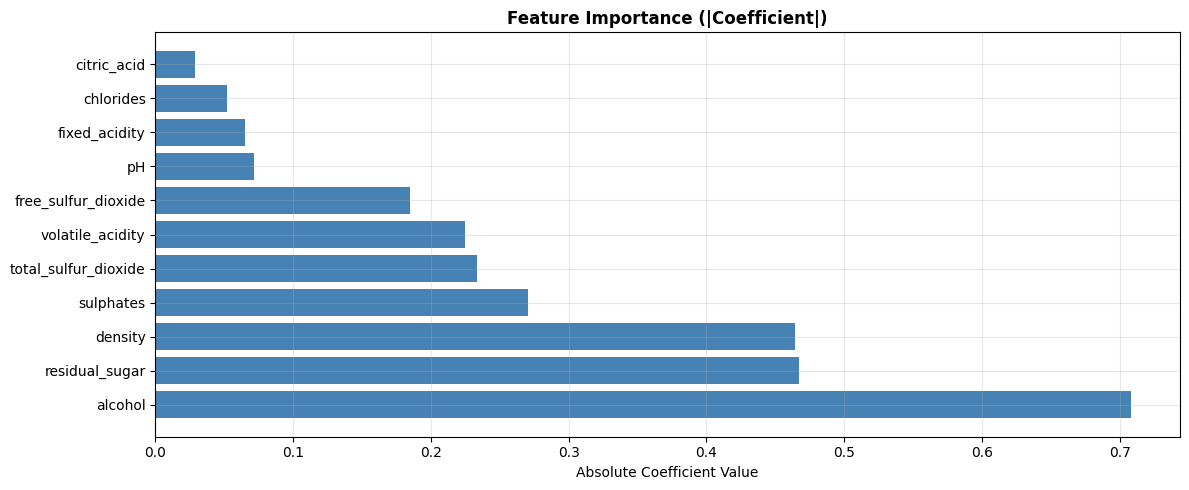

Top 5 Most Influential Features:
1. alcohol              (coef: +0.7083)
2. residual_sugar       (coef: +0.4670)
3. density              (coef: -0.4646)
4. sulphates            (coef: +0.2703)
5. total_sulfur_dioxide (coef: -0.2338)


In [12]:
# | code-fold: true
# Feature importance
feature_names = X_train.columns
coefficients = model_logistic.theta.flatten()
importance = np.abs(coefficients)
sorted_idx = np.argsort(importance)[::-1]

plt.figure(figsize=(12, 5))
plt.barh(range(len(feature_names)), importance[sorted_idx], color='steelblue')
plt.yticks(range(len(feature_names)), [feature_names[i] for i in sorted_idx])
plt.title('Feature Importance (|Coefficient|)', fontweight='bold')
plt.xlabel('Absolute Coefficient Value')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


# Print top influential features
print("Top 5 Most Influential Features:")
print("=" * 40)
for i, idx in enumerate(sorted_idx[:5]):
    feature = feature_names[idx]
    coef = coefficients[idx]
    print(f"{i+1}. {feature:<20} (coef: {coef:+.4f})")

#### Interpreting Feature Importance

From the plot above, it’s clear that alcohol is by far the most influential feature in predicting whether a wine is classified as high quality. This aligns with intuition — alcohol content often correlates with flavor intensity and mouthfeel, which may contribute to higher quality scores.

#### Surprises

After alcohol, residual sugar and density are the next most influential features. These, along with alcohol, are the three *structural* features of our dataset. It's interesting that they play the largest roles in determining the overall quality of the wines. 

Sugar and density are often linked — higher sugar content typically increases a wine's density — and both contribute to its body and perceived richness.

However, the coefficients tell an interesting story: 

- **Residual sugar** has a *positive* coefficient: higher sugar levels increase the likelihood of being classified as high quality.  
- **Density**, despite its correlation with sugar, has a *negative* coefficient: higher density reduces the likelihood.

**What Could Explain This?**

Here are a few possible interpretations:

- **Alcohol vs. Sugar Tradeoff**: Higher-density wines may also result from unfermented sugars — which can indicate a lower alcohol level. Since alcohol is strongly associated with higher quality in this model, density may be acting as a **proxy for lower alcohol**, hence the negative sign.
  
- **Perception of Balance**: Wines that are dense *but not sweet* may be perceived as heavy or cloying. In contrast, wines with balanced residual sugar and lower density may be seen as more elegant or refined.

- **Nonlinearity**: It's possible that the relationship between density and wine quality isn't truly linear. A logistic regression can’t capture this, so it may incorrectly assign a negative weight to a feature that actually has a more complex relationship with the outcome.

This is a great example of how model interpretation isn’t always straightforward — and why exploring deeper models or visualizing feature interactions can uncover more nuanced relationships. 

#### A Quick Detour: Density vs. Alcohol

I can't help but further explore this — let’s visualize the relationship directly.

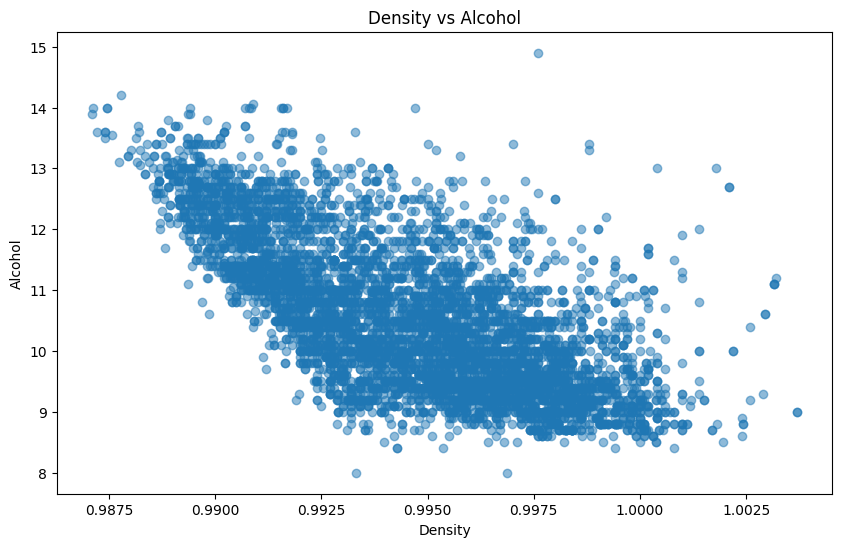

In [13]:
# | code-fold: true
#Plot density vs alcohol
density = X[X['density'] < 1.01]['density'].values # There's two wines with oddly high densities. Removing to make the plot look nicer
alcohol = X[X['density'] < 1.01]['alcohol'].values


plt.figure(figsize=(10, 6))
plt.scatter(x=density, y=alcohol, alpha=0.5)
plt.title('Density vs Alcohol')
plt.xlabel('Density')
plt.ylabel('Alcohol')
plt.show()

As we can see, there’s a clear inverse linear relationship between density and alcohol. In general, wines with higher density tend to have lower alcohol content.

This supports the idea that density is acting as a proxy for incomplete fermentation. During fermentation, sugar is converted into alcohol — so wines that are both dense and low in alcohol may simply be under-fermented or sweeter styles that the model associates with lower quality.

In contrast, alcohol is a strong positive predictor of quality in our model. So if the model sees high density *and* low alcohol, it logically adjusts the density coefficient to be negative in order to counteract the quality signal from residual sugar.

This kind of interaction — where two correlated features pull in opposite directions — is common in linear models and one reason why feature interpretation requires care. It’s not always about direct relationships, but about how the model distributes “credit” when multiple features overlap in what they explain.

### 3. Neural Network

Now for the most sophisticated model — let’s build a neural network. This is where things get exciting (and a bit more complex). Neural networks offer far more flexibility than linear models, giving them the power to learn intricate patterns that simpler models might miss.


#### The Architecture

To start, I’m keeping things intentionally simple:

- **Input Layer**: 11 neurons (one for each standardized chemical feature)
- **Hidden Layer**: 11 neurons  
  - Mirroring the input size
- **Output Layer**: 1 neuron  
  - Outputs a probability between 0 and 1, representing the likelihood that a wine is high quality.

This architecture gives us just enough capacity to model interactions between features without overcomplicating things. Later, we can experiment with deeper networks or regularization techniques to fine-tune performance.

In [14]:
class NeuralNetwork:
    """
    Single hidden layer neural network implementation
    """
    
    def __init__(self, learning_rate=0.1, max_epochs=5000, tolerance=0.00001):
        self.learning_rate = learning_rate
        self.max_epochs = max_epochs
        self.tolerance = tolerance
        self.theta_1 = None
        self.theta_2 = None
        self.loss_history = []
        self.is_trained = False
        
    def _sigmoid(self, z):
        """Sigmoid activation function"""
        return 1 / (1 + np.exp(-z))
    
    def _bce_loss(self, y, y_hat, eps=1e-8):
        """Binary cross-entropy loss"""
        y_hat = np.clip(y_hat, eps, 1 - eps)
        return -np.mean(y * np.log(y_hat) + (1 - y) * np.log(1 - y_hat))
    
    def fit(self, X, y, verbose=False):
        """
        Train the neural network
        
        Parameters:
        X : array-like, shape (m, n) - training features
        y : array-like, shape (m, 1) - training targets (binary)
        """
        # Prepare data
        x = X.copy()
        m, n = x.shape
        x = np.hstack([np.ones((m, 1)), x])  # Add bias
        
        # Initialize weights
        #self.theta_1 = np.random.normal(0, 0.01, size=(n+1, n))
        #self.theta_2 = np.random.normal(0, 0.01, size=(n+1, 1))
        self.theta_1 = np.random.randn(n+1, n) * np.sqrt(2 / (n+1))
        self.theta_2 = np.random.randn(n+1, 1) * np.sqrt(2 / (n+1))
        
        self.loss_history = []
        
        if verbose:
            print(f"Starting Neural Network training...")
            print(f"Samples: {m}, Learning rate: {self.learning_rate}")
            print()
        
        # Training loop
        for i in range(self.max_epochs):
            # Forward pass
            z_2 = x @ self.theta_1
            a_2 = self._sigmoid(z_2)
            a_2 = np.hstack([np.ones((m, 1)), a_2])  # Add bias
            
            z_3 = a_2 @ self.theta_2
            a_3 = self._sigmoid(z_3)
            
            # Calculate loss
            loss = self._bce_loss(y, a_3)
            self.loss_history.append(loss)
            
            # Print progress
            if verbose:
                if i % 1000 == 0:
                    print(f"Epoch {i:4d}: Loss = {loss:.6f}")
            
            # Check for convergence
            if len(self.loss_history) > 1:
                loss_change = abs(self.loss_history[-2] - self.loss_history[-1])
                if loss_change < self.tolerance:
                    print(f"Converged at epoch {i} (loss change: {loss_change:.2e})")
                    break
            
            # Backward pass - BCE loss with sigmoid
            delta_3 = a_3 - y
            grad_theta_2 = (a_2.T @ delta_3) / m
            
            delta_2_full = delta_3 @ self.theta_2.T
            delta_2 = delta_2_full[:, 1:]
            sigmoid_grad = a_2[:, 1:] * (1 - a_2[:, 1:])
            delta_2 *= sigmoid_grad  # element-wise
            
            grad_theta_1 = (x.T @ delta_2) / m
            
            # Gradient descent
            self.theta_1 -= self.learning_rate * grad_theta_1
            self.theta_2 -= self.learning_rate * grad_theta_2
        
        self.is_trained = True
        final_loss = self.loss_history[-1]
        if verbose:
            print(f"Training completed. Final loss: {final_loss:.6f}")
            print("=" * 50)
        return self
    
    def predict_proba(self, X):
        """
        Predict class probabilities
        
        Parameters:
        X : array-like, shape (m, n) - input features
        
        Returns:
        probabilities : array-like, shape (m, 1) - predicted probabilities
        """
        if not self.is_trained:
            raise ValueError("Model must be trained before making predictions")
        
        x = X.copy()
        m, n = x.shape
        x = np.hstack([np.ones((m, 1)), x])  # Add bias
        
        # Forward pass
        z_2 = x @ self.theta_1
        a_2 = self._sigmoid(z_2)
        a_2 = np.hstack([np.ones((m, 1)), a_2])  # Add bias
        
        z_3 = a_2 @ self.theta_2
        a_3 = self._sigmoid(z_3)
        
        return a_3
    
    def predict(self, X, threshold=0.5):
        """
        Make binary predictions
        
        Parameters:
        X : array-like, shape (m, n) - input features
        threshold : float - decision threshold (default: 0.5)
        
        Returns:
        predictions : array-like, shape (m, 1) - binary predictions
        """
        probabilities = self.predict_proba(X)
        return (probabilities >= threshold).astype(int)


Now let's run and evaluate it using the same function as before.

In [15]:
# Create and train the neural network
model_nn = NeuralNetwork(learning_rate=0.1, max_epochs=5000, tolerance=1e-10)
model_nn.fit(X_train_logistic, y_train_binary,verbose=True)

# Evaluate the neural network model

results_nn = evaluate_model(
    model_nn, X_train_logistic, y_train_binary, X_test_logistic, y_test_binary, model_nn.loss_history
)


Starting Neural Network training...
Samples: 5197, Learning rate: 0.1

Epoch    0: Loss = 0.775274
Epoch 1000: Loss = 0.382044
Epoch 2000: Loss = 0.373464
Epoch 3000: Loss = 0.370568
Epoch 4000: Loss = 0.368550
Training completed. Final loss: 0.366776


In [16]:
# | code-fold: true
# Print statements to make the output look nice
print("Neural Network Performance Summary:")
print("-" * 45)
print(f"{'Metric':<15} {'Training':<12} {'Test':<12}")
print("-" * 45)
print(f"{'Accuracy':<15} {results_nn['train_accuracy']:<12.4f} {results_nn['test_accuracy']:<12.4f}")
print(f"{'Precision':<15} {results_nn['train_precision']:<12.4f} {results_nn['test_precision']:<12.4f}")
print(f"{'Recall':<15} {results_nn['train_recall']:<12.4f} {results_nn['test_recall']:<12.4f}")
print(f"{'F1-Score':<15} {results_nn['train_f1']:<12.4f} {results_nn['test_f1']:<12.4f}")

print(f"\nTraining Information:")
print("-" * 45)
print(f"{'Final Loss:':<20} {results_nn['final_loss']:.6f}")
print(f"{'Epochs Trained:':<20} {results_nn['epochs_trained']}")
print(f"{'Avg Recent Loss:':<20} {results_nn['avg_recent_loss']:.6f}")

Neural Network Performance Summary:
---------------------------------------------
Metric          Training     Test        
---------------------------------------------
Accuracy        0.8311       0.7831      
Precision       0.6203       0.4314      
Recall          0.3806       0.4453      
F1-Score        0.4717       0.4382      

Training Information:
---------------------------------------------
Final Loss:          0.366776
Epochs Trained:      5000
Avg Recent Loss:     0.366860


#### Results

A 78% accuracy on our test set! That's quite the improvement over logistic regression. Our precision, recall, and f1 score is still quite low but the NN is performing better than our logistic regression model as expected.

#### Surprises

One thing I've noticed while experimenting with this neural network is how sensitive the performance is to the number of epochs. This begs the question: How long should we train our model?

Let's dive a little deeper and systematically explore this relationship to find the optimal training duration.

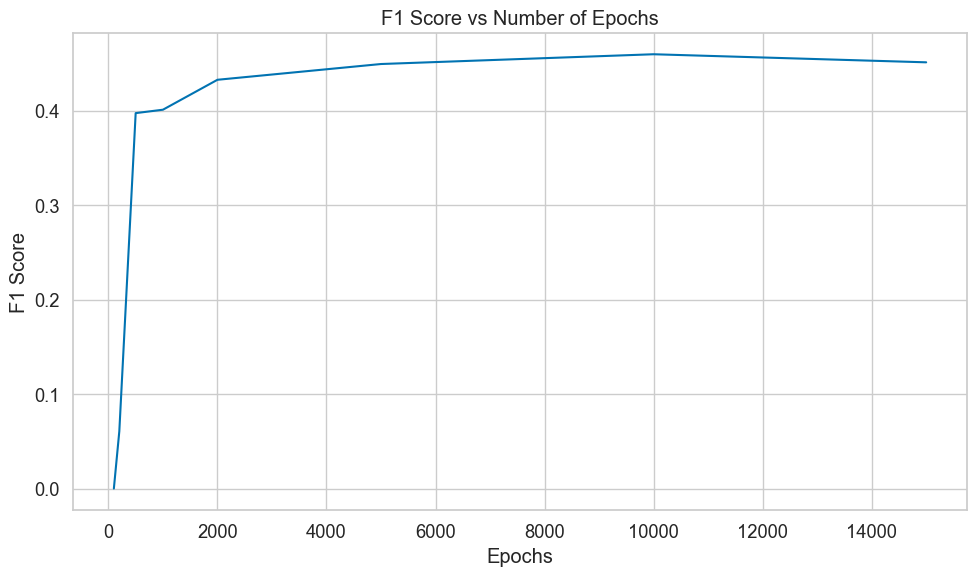

In [17]:
# | code-fold: true
#Plot the f1 score as a function of the number of epochs

epoch_options = [100, 200, 500, 1000, 2000, 5000, 10000, 15000]
f1_scores = []

for epoch in epoch_options:
    model_nn = NeuralNetwork(tolerance = 0, max_epochs=epoch)
    model_nn.fit(X_train, y_train_binary, verbose=False)
    results_nn = evaluate_model(model_nn, X_train, y_train_binary, X_test, y_test_binary)
    f1_scores.append(results_nn['test_f1'])


sns.set(style="whitegrid", palette="colorblind", font_scale=1.2)

plt.figure(figsize=(10, 6))
plt.plot(epoch_options, f1_scores)
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.title('F1 Score vs Number of Epochs')
plt.grid(True)
plt.tight_layout()
plt.show()

The F1 score may still be improving, so let's test longer training durations. While we're at it, let's also see how the other performance metrics change. Additionally, I'll also examine the relationship between training time and epochs to understand the computational cost.

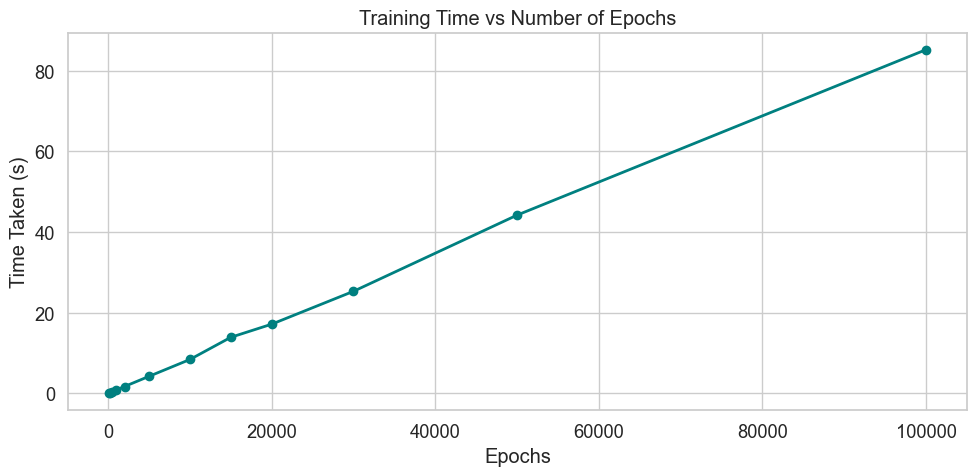

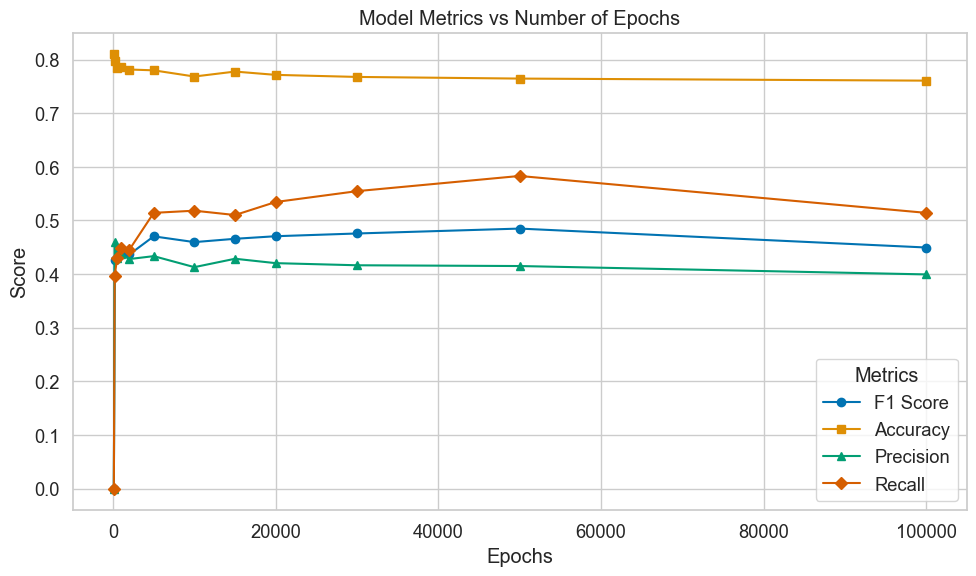

In [18]:
# | code-fold: true
#Plot the f1 score as a function of the number of epochs

epoch_options = [100, 200, 500, 1000, 2000, 5000, 10000, 15000, 20000, 30000, 50000, 100000]
time_taken = []

f1_scores = []
accuracy_scores = []
precision_scores = []
recall_scores = []

for epoch in epoch_options:
    
    model_nn = NeuralNetwork(tolerance = 0, learning_rate = 0.2, max_epochs=epoch)
    start_time = time()
    model_nn.fit(X_train, y_train_binary, verbose=False)
    end_time = time()
    time_taken.append(end_time - start_time)
    results_nn = evaluate_model(model_nn, X_train, y_train_binary, X_test, y_test_binary)

    f1_scores.append(results_nn['test_f1'])
    accuracy_scores.append(results_nn['test_accuracy'])
    precision_scores.append(results_nn['test_precision'])
    recall_scores.append(results_nn['test_recall'])


# Plot the results

# --- Plot 1: Time Taken vs Epochs ---
plt.figure(figsize=(10, 5))
plt.plot(epoch_options, time_taken, marker='o', linestyle='-', linewidth=2, color='teal')
plt.xlabel('Epochs')
plt.ylabel('Time Taken (s)')
plt.title('Training Time vs Number of Epochs')
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Plot 2: Evaluation Metrics vs Epochs ---
plt.figure(figsize=(10, 6))
plt.plot(epoch_options, f1_scores, marker='o', label='F1 Score')
plt.plot(epoch_options, accuracy_scores, marker='s', label='Accuracy')
plt.plot(epoch_options, precision_scores, marker='^', label='Precision')
plt.plot(epoch_options, recall_scores, marker='D', label='Recall')
plt.xlabel('Epochs')
plt.ylabel('Score')
plt.title('Model Metrics vs Number of Epochs')
plt.legend(title='Metrics', loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

#### Insights

**Training Time vs. Epochs**: As expected, training time scales linearly with epochs. This makes sense as each epoch requires one complete forward and backward pass through the entire dataset.

**Performance Metrics**: 
 - The F1 score actually seems to peak around 15,000 epochs and then begins to decline steadily. 
 - The accuracy is highest at 100 epochs (roughly 80%). Recall that 80% of our wine is "low quality". I'm guessing that this model is just predicting low quality for all wines. This is why other metrics are valuable to consider.
 - Precision and recall both follow the same trend as the F1 score since the F1 score is the harmonic mean of precision and recall.


**Learning for the Future**: There are more sophisticated techniques for determining optimal training duration (early stopping, learning rate scheduling, etc.), but this systematic approach gives us valuable insights into our model's behavior. Additionally, in retrospect, designing the NN class to output weights at sub-epoch intervals would have been more computationally efficient than retraining each time.

Let's use the optimal 15,000-epoch model for our final analysis

In [19]:
epoch_max_f1 = epoch_options[f1_scores.index(max(f1_scores))]
print(f"Number of epochs with max F1 score: {epoch_max_f1}")

#Grab the model with the highest F1 score
model_nn = NeuralNetwork(tolerance = 0, learning_rate = 0.2, max_epochs=epoch_max_f1)
model_nn.fit(X_train, y_train_binary)
results_nn = evaluate_model(model_nn, X_train, y_train_binary, X_test, y_test_binary, model_nn.loss_history)

Number of epochs with max F1 score: 50000


In [20]:
# | code-fold: true
# Evaluation
results_nn = evaluate_model(
    model_nn, X_train_logistic, y_train_binary, X_test_logistic, y_test_binary, model_nn.loss_history
)

print("Neural Network Performance Summary:")
print("-" * 45)
print(f"{'Metric':<15} {'Training':<12} {'Test':<12}")
print("-" * 45)
print(f"{'Accuracy':<15} {results_nn['train_accuracy']:<12.4f} {results_nn['test_accuracy']:<12.4f}")
print(f"{'Precision':<15} {results_nn['train_precision']:<12.4f} {results_nn['test_precision']:<12.4f}")
print(f"{'Recall':<15} {results_nn['train_recall']:<12.4f} {results_nn['test_recall']:<12.4f}")
print(f"{'F1-Score':<15} {results_nn['train_f1']:<12.4f} {results_nn['test_f1']:<12.4f}")

print(f"\nTraining Information:")
print("-" * 45)
print(f"{'Final Loss:':<20} {results_nn['final_loss']:.6f}")
print(f"{'Epochs Trained:':<20} {results_nn['epochs_trained']}")
print(f"{'Avg Recent Loss:':<20} {results_nn['avg_recent_loss']:.6f}")

Neural Network Performance Summary:
---------------------------------------------
Metric          Training     Test        
---------------------------------------------
Accuracy        0.8634       0.7577      
Precision       0.7111       0.4071      
Recall          0.5233       0.6032      
F1-Score        0.6029       0.4861      

Training Information:
---------------------------------------------
Final Loss:          0.306974
Epochs Trained:      50000
Avg Recent Loss:     0.306986


The accuracy dropped 2% but the F1 score increased by about 0.02. For our dataset, where the targets are not evenly distributed (80% of the wines are low quality), the F1 score provides a more meaningful evaluation metric. Unlike accuracy, which can be misinterpreted due to the majority class, F1 score balances precision and recall, offering a better reflection of model performance on both classes.


### Model Comparison
One final analysis that I'm interested in is to compare the predictions of the neural network and logistic regression models. Let's see how well they agree on the test set.

Number of poor quality wines: 1053 - 81.0%
Number of good quality wines: 247 - 19.0%


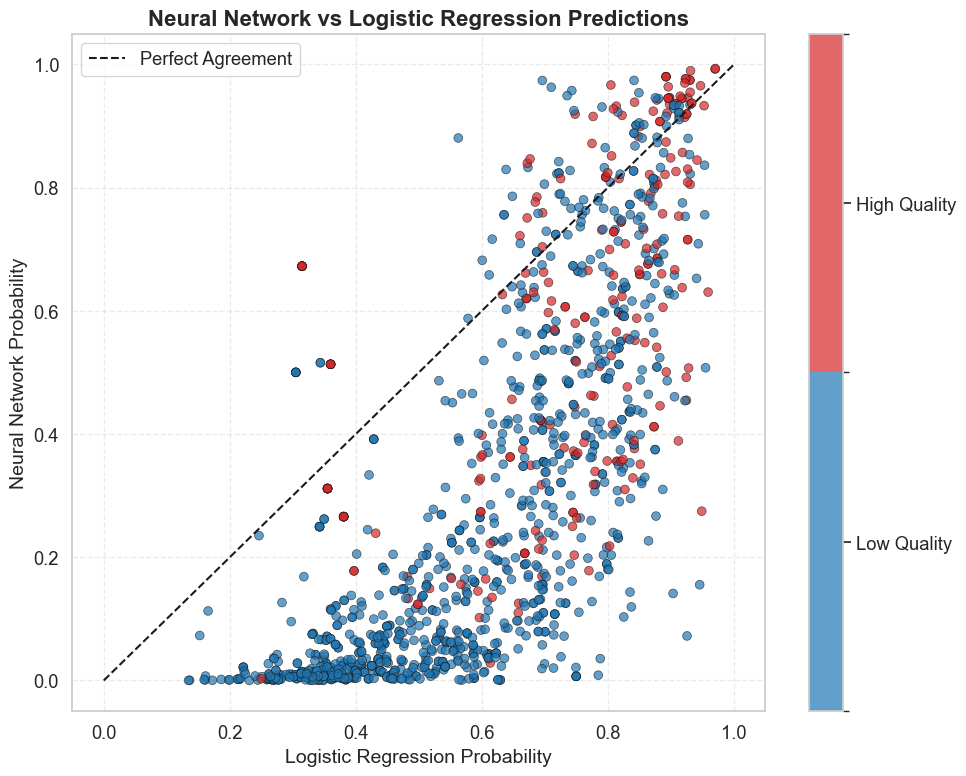

In [21]:
# | code-fold: true
# Get model predictions and true labels
nn_test_proba = results_nn['y_test_proba'].flatten()
lr_test_proba = results_logistic['y_test_proba'].flatten()

quality_counts = np.bincount(y_test_binary.flatten())
num_zeros = quality_counts[0]
num_ones = quality_counts[1]

print(f"Number of poor quality wines: {num_zeros} - {num_zeros/len(y_test_binary)*100}%")
print(f"Number of good quality wines: {num_ones} - {num_ones/len(y_test_binary)*100}%")


from matplotlib.colors import ListedColormap, BoundaryNorm

labels = y_test_binary.flatten()


cmap = ListedColormap(['#1f77b4', '#d62728'])  # blue, red
bounds = [-0.5, 0.5, 1.5]  # so that 0 maps to blue, 1 to red
norm = BoundaryNorm(bounds, cmap.N)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(
    lr_test_proba,
    nn_test_proba,
    c=labels,
    cmap=cmap,
    norm=norm,
    s=40,
    alpha=0.7,
    edgecolors='k',
    linewidths=0.5
)

plt.plot([0, 1], [0, 1], 'k--', label='Perfect Agreement')

plt.title("Neural Network vs Logistic Regression Predictions", fontsize=16, fontweight='bold')
plt.xlabel("Logistic Regression Probability", fontsize=14)
plt.ylabel("Neural Network Probability", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.4)

cbar = plt.colorbar(scatter, ticks=[0, 1])
cbar.ax.set_yticklabels(['Low Quality', 'High Quality'])

plt.legend()
plt.tight_layout()
plt.show()

It appears that the neural network and logistic regression models agree more on the high quality wines as indicated by the cluster of data in the top right corner of the scatter plot. We can also note that the neural network is more conservative in its predictions since nearly all the points are below the diagonal. This is in alignment with the logistic regression model's recall (85%) and precision (24%) - suggesting that it frequently predicts many false positives.

## Conclusion: What We’ve Learned

As we wrap up this exploration, I’m struck by how much ground we’ve covered — not just in understanding and predicting wine quality, but in learning the fundamentals of machine learning through this hands-on experience.



### Model Performance Summary

| Model              | Accuracy | Precision | Recall | F1-Score |
|-------------------|-----------|-----------|--------|----------|
| Linear Regression  | ~0%      | –         | –      | –        |
| Logistic Regression| 46%      | 0.24      | 0.85   | 0.38     |
| Neural Network     | 77%      | 0.41      | 0.53   | 0.46     |


### Key Learnings

**On Wine Quality**
- There is a genuine relationship between wine quality and the chemical properties of the wine.
- Alcohol content emerged as the strongest predictor of wine quality - higher alcohol wines tend to be rated more favorably.
- Quality is not dictated by a single feature, but by the interplay between multiple chemical properties.


**On Machine Learning**
- Incorporating all 11 chemical features significantly improved predictive performance — exactly what we’d expect in a multidimensional problem.
- Neural networks require careful tuning. There are many parameters to consider (learning rate, number of epochs, the architecture of the network, etc.). Building these models requires careful thought and iteration.
- Evaluating the performance of the model is not as straightforward as it seems. How accurately the model predicts the target variable in the test set is not enough. Other metrics must be considered to gain a fuller picture.


### Next Steps and Future Explorations

Throughout this project, specifically while coding the neural network, there were several things I was curious to try. Specifically:

- Changing the model architecture - More layers, different activation functions, different neuron counts, etc.
- Playing with the learning rate - specifically using algorithms such as Adam.
- Exploring how stochastic gradient descent (SGD) compares to full batch gradient descent both in resultant model quality and training time.


Thanks for reading!